# Rook Patch Classification
In this experiment, we classify 2 identical rook patches in terms of their location. We place the rook patch on the top-left and bottom-right of the image. We train a 5x5 filter with zero padded same convolution followed by ReLU, global max pooling and softmax classifier by using SGD optimizer.





In [1]:
import numpy as np
import torch
import torchvision

np.random.seed(1988)  # for reproducibility
torch.backends.cudnn.deterministic = True
torch.manual_seed(1988)
torch.cuda.manual_seed_all(1988)

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()

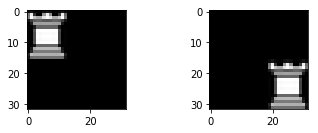

In [2]:
# Reading the images

img1 = plt.imread('class1.png')
img2 = plt.imread('class2.png')

plt.subplot(221)
plt.imshow(img1, cmap='gray')
plt.subplot(222)
plt.imshow(img2, cmap='gray')
plt.show()

In [3]:
# Arranging the inputs

img1 = np.reshape(img1,(1,1,32,32))
img2 = np.reshape(img2,(1,1,32,32))

x_train = np.concatenate((img1, img2), axis=0)
y_train = np.array([0,1])

In [4]:
# Dataloader

class TrainDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def __len__(self):
        return len(self.x_train)
    def __getitem__(self, idx):
        sample = {'images':self.x_train[idx], 'labels':self.y_train[idx]}
        return sample

train_set = TrainDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=1)

results = {}

In [5]:
# Network Design

class RookNet(nn.Module):
        def __init__(self):
            super(RookNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 1, 5, stride=1, padding=2, bias=False)
            self.fc1 = nn.Linear(1 * 1 * 1, 2)
            self.adap_max = nn.AdaptiveMaxPool2d(1)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.adap_max(x)
            x = x.view(-1, 1 * 1 * 1)
            x = self.fc1(x)
            return x     

In [6]:
# Training hyperparameters

num_epochs = 100

In [7]:
# Training the network with 5 different initilizations

for m in range(5):
    print('Round  :{:4d}'.format(m + 1))    
    
    torch.manual_seed(m) # to try different weight init
    rooknet = RookNet()
    if use_gpu:
        rooknet = rooknet.cuda() 
    print(rooknet)          
     
    #******************************************************************#
    ###******************** ROOK TRAINING/TESTING *******************###
    #******************************************************************#

    # Loss functions and optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD([{'params':rooknet.parameters()}], lr=0.1, momentum=0.9)
    
    # Training

    print('RookNet training is starting...')
    
    for epoch in range(num_epochs):
        training_loss = 0.0
        counter = 0.0
        total = 0.0
        corrects = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs = data['images']
            labels = data['labels']
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.view(inputs.shape[0])
            labels = labels.type(torch.LongTensor)

            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            outputs = rooknet(inputs) 
            
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            corrects += torch.sum(predicted == labels)
            counter += 1
            total += labels.shape[0]

        epoch_loss = training_loss / (counter) 
        epoch_acc = corrects.item() / (total)
        print('Epoch:{:4d}'.format(epoch + 1))
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    # Testing

    print('RookNet testing is starting...')

    testing_loss = 0.0
    corrects = 0.0
    total = 0.0
    for data in trainloader:
        images = data['images']
        images = images.type(torch.FloatTensor)
        labels = data['labels']
        labels = labels.view(images.shape[0])
        labels = labels.type(torch.LongTensor)
        
        if use_gpu:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = rooknet(images)

        loss = criterion(outputs, labels)
        testing_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        corrects +=  torch.sum(predicted == labels)

    testing_loss /= total
    acc = 100 * corrects.item() / (total)
    print('testing loss: ',testing_loss)   
    print('Accuracy of the network on the test images: %.4f %%' % (acc))

    results[m] = acc

Round  :   1
RookNet(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (adap_max): AdaptiveMaxPool2d(output_size=1)
)
RookNet training is starting...
Epoch:   1
Loss: 0.7982 Acc: 0.5000
Epoch:   2
Loss: 0.7669 Acc: 0.5000
Epoch:   3
Loss: 0.7332 Acc: 0.0000
Epoch:   4
Loss: 0.7272 Acc: 0.5000
Epoch:   5
Loss: 0.7224 Acc: 0.5000
Epoch:   6
Loss: 0.7164 Acc: 0.5000
Epoch:   7
Loss: 0.7101 Acc: 0.5000
Epoch:   8
Loss: 0.7056 Acc: 0.5000
Epoch:   9
Loss: 0.7050 Acc: 0.5000
Epoch:  10
Loss: 0.7083 Acc: 0.0000
Epoch:  11
Loss: 0.7134 Acc: 0.5000
Epoch:  12
Loss: 0.7174 Acc: 0.5000
Epoch:  13
Loss: 0.7189 Acc: 0.0000
Epoch:  14
Loss: 0.7184 Acc: 0.0000
Epoch:  15
Loss: 0.7164 Acc: 0.0000
Epoch:  16
Loss: 0.7139 Acc: 0.5000
Epoch:  17
Loss: 0.7112 Acc: 0.5000
Epoch:  18
Loss: 0.7090 Acc: 0.5000
Epoch:  19
Loss: 0.7075 Acc: 0.5000
Epoch:  20
Loss: 0.7068 Acc: 0.0000
Epoch:  21
Loss: 0.7068 Acc: 0.0

In [8]:
# Printing the results and statistics

print('rook results: ',results)

acc = np.zeros(m+1)

for i in range(m+1):
    acc[i] = results[i]
       
mean = np.mean(acc)    
std = np.std(acc)

print('mean: {:.4f} std: {:.4f}'.format(mean, std))

rook results:  {0: 100.0, 1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0}
mean: 100.0000 std: 0.0000
